In [17]:
import sys; sys.path.append('../src/sde_hjb_solver')

import matplotlib.pyplot as plt
import numpy as np

from hjb_solver_1d_st import SolverHJB1D
from controlled_sde_1d import DoubleWellMGF1D
from base_parser import get_base_parser
from config import DATA_ROOT_DIR

In [36]:
# sde setting
alphas = [1, 2, 5, 10]
betas = np.array([1, 1, 1, 1])
sigmas = np.sqrt(2 / betas)
domain = (-2,  2)
target_set = (1, 2)

# hjb solver
h = 0.001

# plots
assert len(alphas) == betas.shape[0], ''
n_alphas = len(alphas)
xlim = (-1.75, 1.75)

# directory
dir_path = DATA_ROOT_DIR + '/notebooks/'

In [19]:
# preallocate solutions
x = np.arange(domain[0], domain[1] + h, h)
x_bumpy = np.expand_dims(x, axis=1) 
Nh = x.shape[0]
potentials, gradients, psis, value_fs, controls, perturbed_potentials, perturbed_drifts, mfhts, \
    = [np.empty((n_alphas, Nh)) for _ in range(8)]

In [20]:
#sde.gradient

In [21]:
# get solutions for each setting
for i in range(n_alphas):
    
    # initialize sde object
    sde = DoubleWellMGF1D(
        beta=betas[i],
        alpha=np.array([alphas[i]]), 
        lam=1.0,
        domain=domain,
        target_set=target_set,
    )

    # initialize hjb solver object
    sol_hjb = SolverHJB1D(sde, h)
    
    # compute hjb solution 
    sol_hjb.solve_bvp()
    sol_hjb.compute_value_function()
    sol_hjb.compute_optimal_control()
    sol_hjb.save()

    # compute mfht
    sol_hjb.mfht = sde.compute_mfht(delta=1e-4)

    # save
    sol_hjb.save()
    
    sol_hjb.get_perturbed_potential_and_drift() 
    
    # get solution
    potentials[i] = np.squeeze(sde.potential(x_bumpy))
    gradients[i] = np.squeeze(sde.gradient(x_bumpy))
    psis[i] = sol_hjb.psi
    value_fs[i] = sol_hjb.value_function
    perturbed_potentials[i] = sol_hjb.perturbed_potential
    controls[i] = np.squeeze(sol_hjb.u_opt)
    perturbed_drifts[i] = np.squeeze(sol_hjb.perturbed_drift)
    mfhts[i] = sol_hjb.mfht

In [22]:
labels = []                                                                        
for i in range(n_alphas):                                                                         
    labels.append(r'$\alpha={}$'.format(alphas[i]))                                                                        

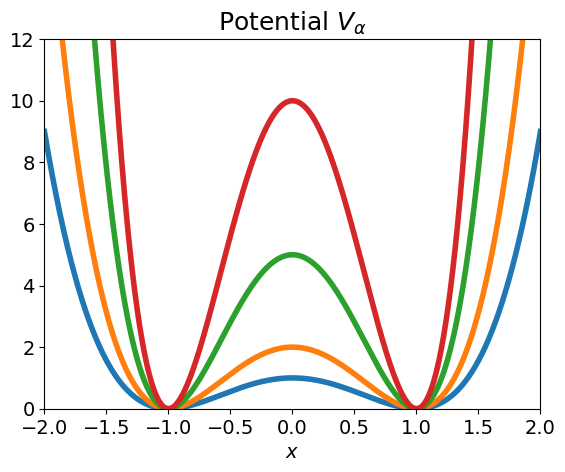

In [23]:
# plot potential
fig, ax = plt.subplots()
ax.set_title(r'Potential $V_{\alpha}$')
ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylim(-0, 12)
for i in range(n_alphas):
    ax.plot(x, potentials[i], label=labels[i])
plt.show()

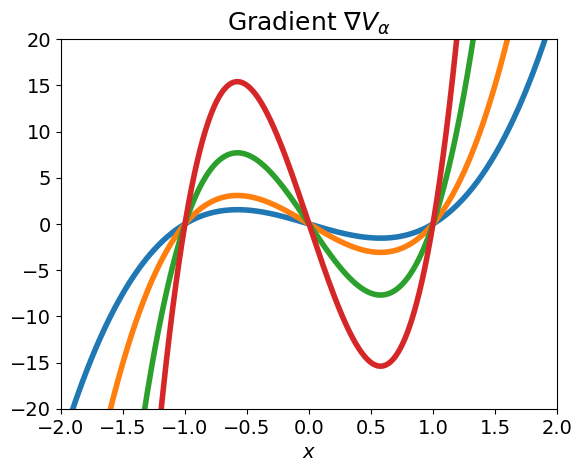

In [24]:
# plot gradient
fig, ax = plt.subplots()
ax.set_title(r'Gradient $\nabla V_\alpha$')
ax.set_xlabel(r'$x$')
ax.set_xlim(-2, 2)
ax.set_ylim(-20, 20)
for i in range(n_alphas):
    ax.plot(x, gradients[i], label=labels[i])
plt.show()

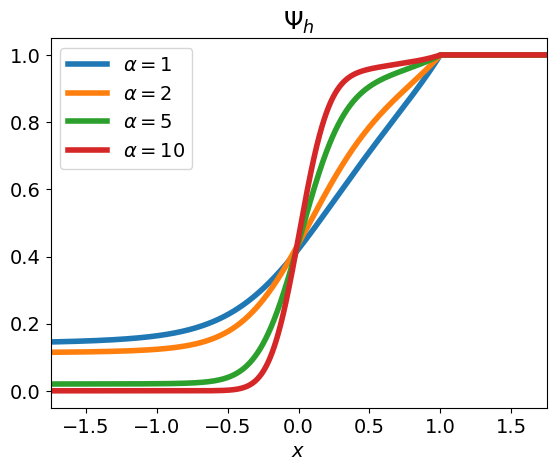

In [31]:
# plot psi
fig, ax = plt.subplots()
ax.set_title(r'$\Psi_h$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(-0.05, 1.05)
for i in range(n_alphas):
    ax.plot(x, psis[i], label=labels[i])
plt.legend()
plt.savefig(dir_path + 'hjb_alphas_psi.pdf', bbox_inches='tight')

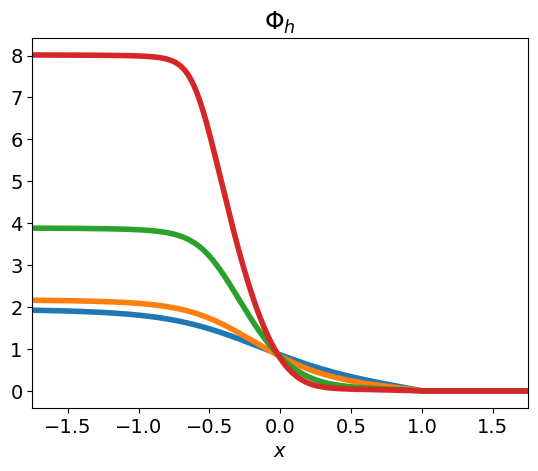

In [32]:
# plot value function
fig, ax = plt.subplots()
ax.set_title(r'$\Phi_h$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
for i in range(n_alphas):
    ax.plot(x, value_fs[i], label=labels[i])
plt.savefig(dir_path + 'hjb_alphas_value-function.pdf', bbox_inches='tight')

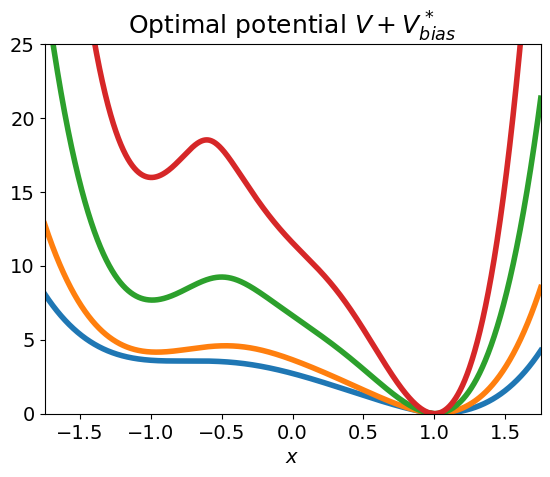

In [33]:
# plot controlled potential
fig, ax = plt.subplots()
ax.set_title(r'Optimal potential $V + V_{bias}^*$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(0, 25)
for i in range(n_alphas):
    ax.plot(x, perturbed_potentials[i], label=labels[i])
plt.savefig(dir_path + 'hjb_alphas_perturbed-potential.pdf', bbox_inches='tight')

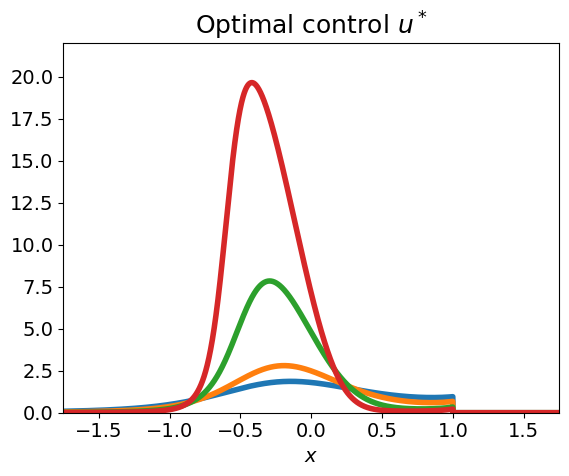

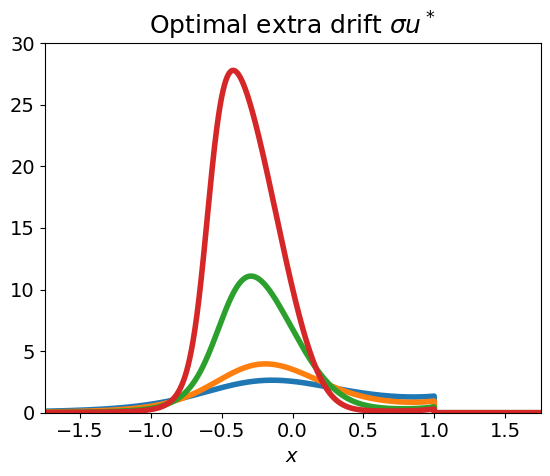

In [41]:
# plot controls
fig, ax = plt.subplots()
ax.set_title(r'Optimal control $u^*$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(0, 22)
for i in range(n_alphas):
    ax.plot(x, controls[i], label=labels[i])
plt.savefig(dir_path + 'hjb_alphas_control.pdf', bbox_inches='tight')

# plot extra drift
fig, ax = plt.subplots()
ax.set_title(r'Optimal extra drift $\sigma u^*$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(0, 30)
for i in range(n_alphas):
    ax.plot(x, sigmas[i]*controls[i], label=labels[i])
plt.savefig(dir_path + 'hjb_alphas_extra-drift.pdf', bbox_inches='tight')
plt.show()

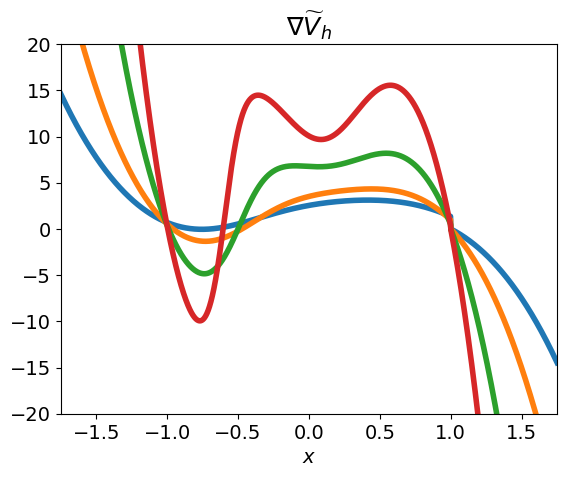

In [42]:
# plot controlled drift
fig, ax = plt.subplots()
ax.set_title(r'$\nabla \widetilde{V}_h$') 
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(-20, 20)
for i in range(n_alphas):
    ax.plot(x, perturbed_drifts[i], label=labels[i])
plt.show()

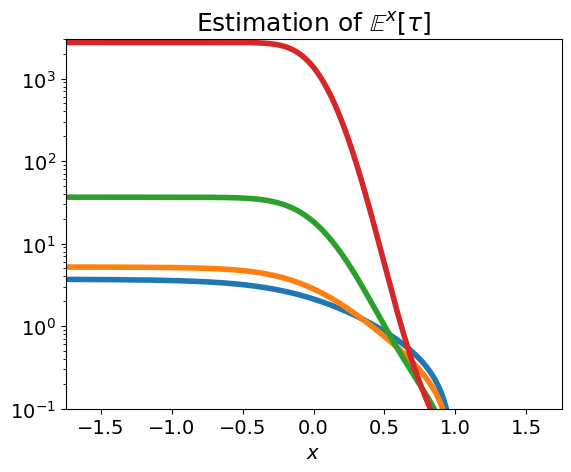

In [44]:
# mean first hitting time
fig, ax = plt.subplots()
ax.set_title(r'Estimation of $\mathbb{E}^x[\tau]$')
ax.set_xlabel(r'$x$')
ax.set_xlim(xlim)
ax.set_ylim(1e-1, 3000)#4000)
for i in range(n_alphas):
    ax.semilogy(x, mfhts[i], label=labels[i])
plt.savefig(dir_path + 'hjb_alphas_mfht.pdf', bbox_inches='tight')